# Intro to Advanced ML

## Student: Rodolfo Lerma

## Multiclass Classification

While binary classifiers are used to distinguish between two classes (e.g. detect if a transaction is a fraudulent one, classify an email into either spam or non-spam and etc.), multiclass classifiers distinguish between more than two classes. 

There are various ways that we can use to perform multiclass classification by leveraging any binary classifiers. In this exercise, you will implement two such strategies for multiclass classification: _One-versus-all_ strategy and _One-versus-one_ strategy.

- **One-versus-all (OvA)**: In this strategy, we train a single binary classifier per class, with the samples of that class as positive samples and all other samples as negatives. During inference, we get the prediction from each classifier and select the class with the highest score. This strategy is also called the one-versus-the-rest strtegey. 

- **One-versus-one (OvO)**: In this strategy, we train a binary classifier for every pair of classes. If there are N classes in the problem, you need to train N * (N-1) / 2 classifiers. During inference, we have to run through all N * (N-1) / 2 classifiers and ses which class wins the most votes. The main advantage of OvO strategy is that each binary classifier only needs to be train on the part of the training dataset for the two classes that it needs to separate. 

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# make this notebook's output stable across runs
np.random.seed(0)

## Avila Dataset

In this lab assignment, we use the [Avila](https://archive.ics.uci.edu/ml/datasets/Avila) data set has been extracted from 800 images of the the "Avila Bible", a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain.  
The palaeographic analysis of the  manuscript has  individuated the presence of 12 copyists. The pages written by each copyist are not equally numerous. 
Each pattern contains 10 features and corresponds to a group of 4 consecutive rows.

The prediction task consists in associating each pattern to one of the 12 copyists (labeled as: A, B, C, D, E, F, G, H, I, W, X, Y).
The data have has been normalized, by using the Z-normalization method, and divided in two data sets: a training set containing 10430 samples, and a test set  containing the 10437 samples.


In [2]:
# Load train and test data from CSV files.
train = pd.read_csv("avila-tr.txt", header=None)
test = pd.read_csv("avila-ts.txt", header=None)

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

### Output the number of images in each class in the train and test datasets.

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [4]:
train.shape

(10430, 11)

In [5]:
train[10].value_counts()

A    4286
F    1961
E    1095
I     831
X     522
H     519
G     446
D     352
Y     266
C     103
W      44
B       5
Name: 10, dtype: int64

In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A


In [7]:
test.shape

(10437, 11)

In [8]:
test[10].value_counts()

A    4286
F    1962
E    1095
I     832
X     522
H     520
G     447
D     353
Y     267
C     103
W      45
B       5
Name: 10, dtype: int64

Question 1.1: Check for missing Data

In [9]:
train.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

No missing data on the training dataset

In [10]:
test.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

No missing data on the test dataset as well.

## Data Exploration

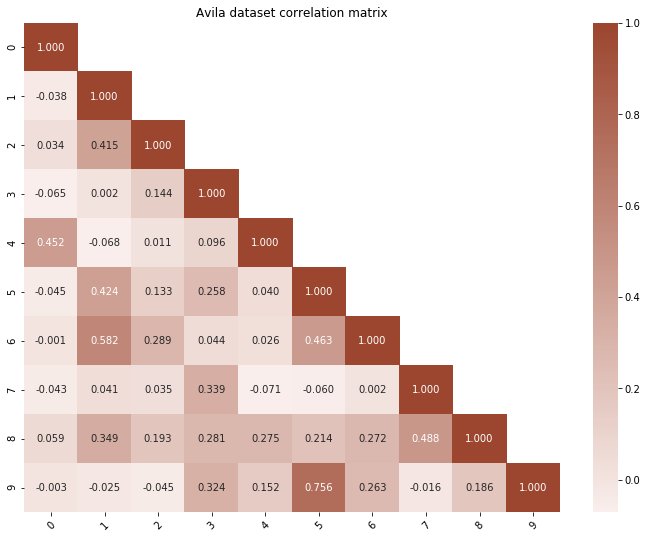

In [11]:
import seaborn as sns

corr = train.corr()
hm_fig, hm_ax = plt.subplots(figsize=(12,9))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Avila dataset correlation matrix')
hm_ax.patch.set_alpha(0);

### Question 1.2: Apply Z-normalization to data

In [12]:
#Columns to list
columns_train = train.columns.to_list()
columns_test = test.columns.to_list()

#Removing the target variable
columns_train.remove(10)
columns_test.remove(10)

In [13]:
def normalization_format(numeric_columns, df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df[numeric_columns])
    data_scaled = scaler.transform(df[numeric_columns])
    df1 = pd.DataFrame(data_scaled, columns = numeric_columns)
    return df1

In [14]:
#Normalization of train dataset
train_norm = normalization_format(columns_train, train)

#Normalization of test dataset
test_norm = normalization_format(columns_test, test)

### Question 2.1: Write a method to train multiple logistic regression models performing One vs All (OvA) classification. The method allows you to pass in training features, and target. The method returns a list of models and their associated labels. 

Within the method:
- Determine the list of classes
- Create a place to store all the models
- For each class, train a model with the target variable set to 1 and 0 for all other classes
- Return the list of models trained and associated labels.

In [118]:
##EXAMPLE

# yei = yup[10].astype('category')
# labels = sorted(yei.unique())
# n_labels = len(labels)
# model_labels = [None] * n_labels

# for i in range(n_labels):
#     label = labels[i]
#     print("Train Logistic Regression model for class {}".format(label))
#     # Update the label according to OvA strategy
#     # Transforming the label/target column to a One Vs All for each of the categories
#     binary_labels = []
#     for j in range(len(yup[10])):
#         if yup[10][j] == label:
#             z = 1
#         else:
#             z = 0
#         binary_labels.append(z)
#     model_labels[i] = binary_labels

In [15]:
def trainOvA(x, y):
    """
    TODO: Train the multiclass classifier using OvA strategy. 
    """
    from sklearn import linear_model
    
    labels = y.astype('category')
    labels = sorted(labels.unique())
    n_labels = len(labels)
    print("number of classes is {}".format(n_labels))

    #Create model
    models = [None] * n_labels
    model_labels = [None] * n_labels     

    for i in range(n_labels):
        label = labels[i]
        print("Train Logistic Regression model for class {}".format(label))
        # update the label according to OvA strategy
        # Transforming the label/target column to a One Vs All for each of the categories
        binary_labels = []
        for j in range(len(y)):
            if y[j] == label:
                z = 1
            else:
                z = 0
            binary_labels.append(z)
        
        # Train model
        lr = linear_model.LogisticRegression()
        models[i] =  lr.fit(x, binary_labels)
        model_labels[i] = binary_labels
        
    return models, model_labels, labels

### Question 2.2: Write a method that leverage the multiple models train for OvA, and outputs the majority class.

In [29]:
def predictOvA(models, labels, x):
    """
    TODO: Make predictions on multiclass problems using the OvA strategy. 
    """
    if models == None:
        sys.exit("The model has not been trained yet. Please call train() first. Exiting...")

    #Create prediction
    n_labels = len(labels)
    proba_prediction = [None] * n_labels 
    prediction = [None] * n_labels
    positive_proba = [None] * n_labels
    
    for i in range(n_labels):
        proba_prediction[i] = models[i].predict_proba(x)
        w = proba_prediction[i]
        positive_proba[i] = w[:,1]
        prediction[i] = models[i].predict(test_norm)
    
    df_proba = pd.DataFrame()
    for i in range(n_labels):
        df_proba[i] = positive_proba[i]
        
    df_proba.columns = labels
    
    return df_proba, df_proba.idxmax(axis=1).values

In [113]:

# labels = sorted(train[10].unique())

# n_labels = len(labels)
# proba_prediction = [None] * n_labels 
# prediction = [None] * n_labels
# positive_proba = [None] * n_labels

# for i in range(n_labels):
#     proba_prediction[i] = models[i].predict_proba(test_norm)
#     x = proba_prediction[i]
#     positive_proba[i] = x[:,1]
#     prediction[i] = models[i].predict(test_norm)

# df_proba = pd.DataFrame()
# for i in range(n_labels):
#     df_proba[i] = positive_proba[i]

### Question 2.3: Train OvA model on the Avila dataset

In [17]:
target_train = train[10]
target_test = test[10]

In [18]:
from sklearn.linear_model import LogisticRegression
models, model_labels, labels_list  = trainOvA(train_norm, target_train)

number of classes is 12
Train Logistic Regression model for class A
Train Logistic Regression model for class B
Train Logistic Regression model for class C
Train Logistic Regression model for class D
Train Logistic Regression model for class E
Train Logistic Regression model for class F
Train Logistic Regression model for class G
Train Logistic Regression model for class H
Train Logistic Regression model for class I
Train Logistic Regression model for class W
Train Logistic Regression model for class X
Train Logistic Regression model for class Y


### Question 2.4: Predict and evalutate the results of your model

In [20]:
labels = test[10].astype('category')
labels = sorted(labels.unique())

In [30]:
df_proba, te_z_ova = predictOvA(models, labels, test_norm)

In [25]:
target_test_list = target_test.tolist()
prediction_test_list = te_z_ova.tolist()

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

ova_accuracy = accuracy_score(target_test, te_z_ova)
ova_confuction_matrix = confusion_matrix(target_test, te_z_ova)

print("Accuracy of OvA classifier is {}.".format(ova_accuracy))
print("Confusion matrix of OvA classifier: \n {}".format(ova_confuction_matrix))

Accuracy of OvA classifier is 0.5279294816518156.
Confusion matrix of OvA classifier: 
 [[4061   10    3    0   28  101    0   12   54    0   12    5]
 [   0    5    0    0    0    0    0    0    0    0    0    0]
 [  69    4    0    0   10   12    0    0    8    0    0    0]
 [ 301    0    0    0   14   13    0   12   11    0    2    0]
 [ 834    2    0    0  114   55    0   17   23    0   49    1]
 [1819   10    2    0    3   84    0    4   34    0    2    4]
 [ 356    0    0    0    4   78    0    5    1    0    3    0]
 [ 324    0    0    0   30  102    0   44   19    0    1    0]
 [  51    0    0    1    1    6    0    4  743    0   15   11]
 [  35    0    0    0    9    0    0    0    0    0    1    0]
 [  70    0    0    0    9    0    0    7   52    0  367   17]
 [  43    0    0    0    1    0    0    0  103    0   28   92]]


Text(0.5, 33.0, 'Predicted label')

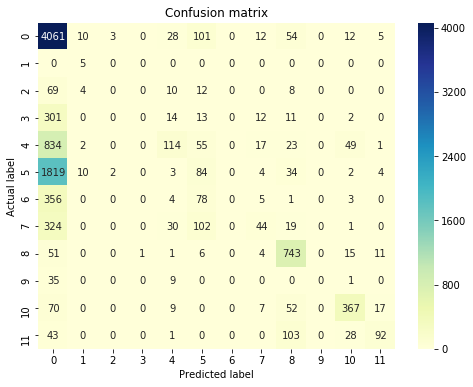

In [43]:
import seaborn as sns

#Confusion matrix
class_names = labels # name of classes
fig, ax = plt.subplots(figsize=(8,6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(ova_confuction_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
labels

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W', 'X', 'Y']

It is possible to see that the performance of the model is bad, just slighly above average. This was expected given that some optimization is needed as the OVR strategy might have problems with class imbalance situations.

---

### Question 3.1: Develop a method that trains a list of models based on the OvO stragety for multiclass classification using logistic regression. 

In [98]:
def trainOvO(x, y, labels):
    """
    TODO: Train the multiclass classifier using OvO strategy. 
    """
    #labels = sorted(y.unique())
    n_labels = len(labels)
    n_models = int(len(labels) * (len(labels) - 1) / 2)
    print("number of classes is {}".format(n_labels))
    
    models = []
    model_labels = []
    model_idx = []
    
    for i in range(n_labels):
        for j in range(i+1, n_labels):
            label_i = labels[i]
            label_j = labels[j]
            print("Train Logistic Regression model to distinguish {} and {}".format(label_i, label_j))

            # update the label according to OvA strategy
            df_target =  y.loc[y.isin([label_i, label_j])]
            model_index = df_target.index.values.tolist()
            
            train_x = x.iloc[model_index]
            train_y = y.iloc[model_index]

            # construct the logistic regression instance
            lr = LogisticRegression(solver = 'liblinear')
            
            #Do not forget to fit
            model =  lr.fit(train_x, train_y) 
            models.append(model)
            model_labels.append(train_y)
            model_idx.append(model_index)
        
    return models, model_labels, model_idx

In [102]:
# train_1 = train.copy()
# train_target_1 = train_1[10]
# train_target_1 = train_target_1.astype('category')  
# train_1.drop(columns = 10, inplace = True)

# n_labels = len(labels)
# n_models = int(len(labels) * (len(labels) - 1) / 2)
# print("number of classes is {}".format(n_labels))

# models = [None] * n_models
# model_labels = [None] * n_models
# model_index = [None] * n_models
# model_idx = 0
# other = []

# for i in range(n_labels):
#     for j in range(i+1, n_labels):
#         label_i = labels[i]
#         label_j = labels[j]
#         print("Train Logistic Regression model to distinguish {} and {}".format(label_i, label_j))
        
#         #df =  test[test[10] == label_i]
#         df_k =  train.loc[train[10].isin([label_i, label_j])]
#         model_index = df_k.index.values.tolist()
        
#         train_x = train_1.iloc[model_index]
#         train_y = train_target_1.iloc[model_index]
        
#         lr = LogisticRegression()
#         models =  lr.fit(train_x, train_y) 
#         other.append(models)

### Question 3.2: Write a method that leverage the multiple models train for OvO, and outputs the majority class.

In [124]:
def predictOvO(models, labels, x):
    """
    TODO: Make predictions on multiclass problems using the OvO strategy. 
    """
    if models == None:
        sys.exit("The model has not been trained yet. Please call train() first. Exiting...")

    n_models = len(models)
    predictions = []
    model_num = []
    
    for i in range(n_models):
        print("Working on Model {}".format(i))        
        pred = models[i].predict(x)
        predictions.append(pred)
        model_num.append(i)
    
    df_ovo = pd.DataFrame(predictions).T
    
    return df_ovo.mode(axis=1).iloc[:, 0].values , model_num

In [119]:
# df_ovo = pd.DataFrame(predictions).T
# df_ovo.mode(axis=1).iloc[:, 0].values

In [120]:
# df_proba = pd.DataFrame()
# for i in range(n_labels):
#     df_proba[i] = positive_proba[i]

# df_proba.columns = labels

In [121]:
# n_models = len(models)
# predictions = []

# for i in range(n_models):
#     print("Working on Model {}".format(i)) 
#     pred = models[i].predict(test_norm)
#     predictions.append(pred)

In [110]:
# predictions.mode(axis=1).iloc[:, 0].values

### Question 3.3: Train OvO model on the Avila dataset

In [99]:
models, labels, indexes = trainOvO(train_norm, target_train, labels)

number of classes is 12
Train Logistic Regression model to distinguish A and B
Train Logistic Regression model to distinguish A and C
Train Logistic Regression model to distinguish A and D
Train Logistic Regression model to distinguish A and E
Train Logistic Regression model to distinguish A and F
Train Logistic Regression model to distinguish A and G
Train Logistic Regression model to distinguish A and H
Train Logistic Regression model to distinguish A and I
Train Logistic Regression model to distinguish A and W
Train Logistic Regression model to distinguish A and X
Train Logistic Regression model to distinguish A and Y
Train Logistic Regression model to distinguish B and C
Train Logistic Regression model to distinguish B and D
Train Logistic Regression model to distinguish B and E
Train Logistic Regression model to distinguish B and F
Train Logistic Regression model to distinguish B and G
Train Logistic Regression model to distinguish B and H
Train Logistic Regression model to distin

### Question 3.4: Predict and evalutate the results of your model

In [125]:
te_z_ovo, model_num = predictOvO(models, labels, test_norm)

Working on Model 0
Working on Model 1
Working on Model 2
Working on Model 3
Working on Model 4
Working on Model 5
Working on Model 6
Working on Model 7
Working on Model 8
Working on Model 9
Working on Model 10
Working on Model 11
Working on Model 12
Working on Model 13
Working on Model 14
Working on Model 15
Working on Model 16
Working on Model 17
Working on Model 18
Working on Model 19
Working on Model 20
Working on Model 21
Working on Model 22
Working on Model 23
Working on Model 24
Working on Model 25
Working on Model 26
Working on Model 27
Working on Model 28
Working on Model 29
Working on Model 30
Working on Model 31
Working on Model 32
Working on Model 33
Working on Model 34
Working on Model 35
Working on Model 36
Working on Model 37
Working on Model 38
Working on Model 39
Working on Model 40
Working on Model 41
Working on Model 42
Working on Model 43
Working on Model 44
Working on Model 45
Working on Model 46
Working on Model 47
Working on Model 48
Working on Model 49
Working on

In [ ]:

ovo_accuracy = #to do
ovo_confuction_matrix = #to do


print("Accuracy of OvO classifier is {}.".format(ovo_accuracy))
print("Confusion matrix of OvO classifier: \n {}".format(ovo_confuction_matrix))

### Question 4.1: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) within sklearn supports two approaches for solving multi-class problems: 'ovr', 'multinomial'. Try out both approaches, and evaluate compare the performance agains what you developed in questions 2 and 3.

In [ ]:
clf = #to do
y_ovr = #predict (to do)

ovr_accuracy = #to do
ovr_confuction_matrix = #to do


print("Accuracy of OvR classifier is {}.".format(ovr_accuracy))
print("Confusion matrix of OvR classifier: \n {}".format(ovr_confuction_matrix))

In [ ]:
#class = multinomial
clf = #to do
y_multinomial = #to do

multinomial_accuracy = #to do
multinomial_confuction_matrix = #to do


print("Accuracy of OvO classifier is {}.".format(multinomial_accuracy))
print("Confusion matrix of OvO classifier: \n {}".format(multinomial_confuction_matrix))

### Question 4: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.